In [1]:
import os
import glob
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
Root_Dir = 'drive/MyDrive/COVID-19ChestCTImageSegmentation_dataset/'

In [86]:
train_data_path = list()

for i in range(len(glob.glob(f'{Root_Dir}/Train/Train_v*_ct.nii.gz'))):
  ct_path = f'{Root_Dir}/Train/Train_v{i+1:04}_ct.nii.gz'
  msk_path = f'{Root_Dir}/Train/Train_v{i+1:04}_seg.nii.gz'

  train_data_path.append((ct_path, msk_path))
  
len(train_data_path)

120

In [87]:
valid_data_path = list()

for i in range(len(glob.glob(f'{Root_Dir}/Validation/Validation_v*_ct.nii.gz'))):
  ct_path = f'{Root_Dir}/Validation/Validation_v{i+1:04}_ct.nii.gz'
  msk_path = f'{Root_Dir}/Validation/Validation_v{i+1:04}_seg.nii.gz'

  valid_data_path.append((ct_path, msk_path))
  
len(valid_data_path)

50

In [88]:
test_data_path = list()

for i in range(len(glob.glob(f'{Root_Dir}/Test/Test_v*_ct.nii.gz'))):
  ct_path = f'{Root_Dir}/Test/Test_v{i+1:04}_ct.nii.gz'
  msk_path = f'{Root_Dir}/Test/Test_v{i+1:04}_seg.nii.gz'

  test_data_path.append((ct_path, msk_path))
  
len(test_data_path)

79

In [89]:
index = 10

In [90]:
ct_img = ni.load(train_data_path[index][0]).get_fdata()
msk_img = ni.load(train_data_path[index][1]).get_fdata()

In [42]:
ct_img[ct_img < -1024] = -1024
ct_img[ct_img > 400] = 400
ct_img = (ct_img+1024)/(1024 + 400)

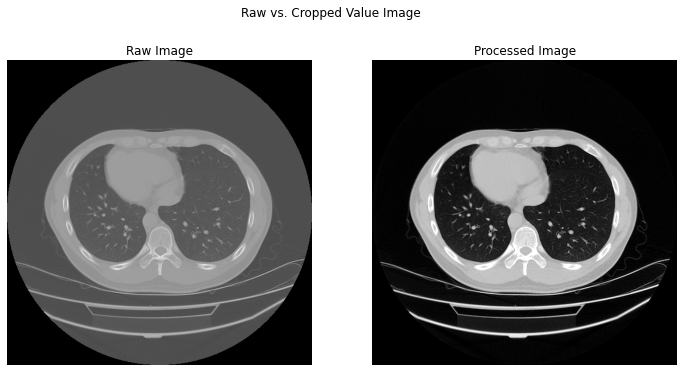

In [82]:
slice_num = 25
origial_img = ct_img[:,:,slice_num].copy()

ct_img[ct_img < -1024] = -1024
ct_img[ct_img > 400] = 400
ct_img = (ct_img+1024)/(1024 + 400)

slice_img = ct_img[:,:,slice_num]

plt.figure(figsize=(12,6))
plt.suptitle("Raw vs. Cropped Value Image")

plt.subplot(1,2,1)
plt.imshow(np.rot90(origial_img, k=-1), cmap='gray')
plt.title('Raw Image')

plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.rot90(slice_img, k=-1), cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.show()


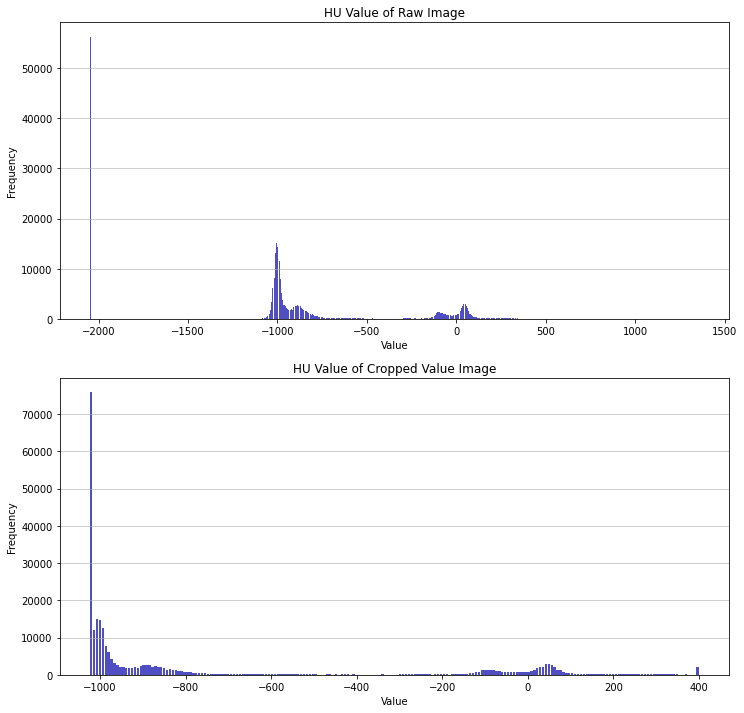

In [79]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
n, bins, patches = plt.hist(x=origial_img.flatten(), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('HU Value of Raw Image')
maxfreq = n.max()

plt.subplot(2,1,2)
n, bins, patches = plt.hist(x=slice_img.flatten(), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('HU Value of Cropped Value Image')
maxfreq = n.max()

# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

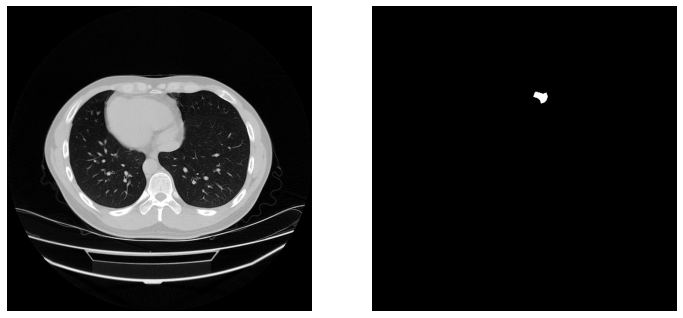

In [36]:
slice_num = 25

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.rot90(ct_img[:,:,slice_num], k=-1), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.rot90(msk_img[:,:,slice_num], k=-1), cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
counter = 0
for i, (ct_file, seg_file) in enumerate(train_data_path):
  ct_img = ni.load(ct_file).get_fdata()
  ct_img[ct_img < -1024] = -1024
  ct_img[ct_img > 400] = 400
  ct_img = (ct_img+1024)/(1024 + 400)

  assert ct_img.shape[0] == 512 and ct_img.shape[1] == 512, f'Size error in {ct_file}, shape is {ct_img.shape}'

  msk_img = (ni.load(seg_file).get_fdata() > 0.5).astype('int')

  for j in range(msk_img.shape[-1]):
    if msk_img[:,:,j].sum() >= 1:
      counter += 1
      np.save(f'{Root_Dir}/PairedTrainData/Train_pairs_{counter:04}.npy', np.array((ct_img[:,:,j],msk_img[:,:,j])))

  # if i == 1:
  #   break

  print(f'{(i+1)/len(train_data_path):.2%} - {counter}   ', end='\r')

In [ ]:
counter = 0
for i, (ct_file, seg_file) in enumerate(valid_data_path):
  ct_img = ni.load(ct_file).get_fdata()
  ct_img[ct_img < -1024] = -1024
  ct_img[ct_img > 400] = 400
  ct_img = (ct_img+1024)/(1024 + 400)

  assert ct_img.shape[0] == 512 and ct_img.shape[1] == 512, f'Size error in {ct_file}, shape is {ct_img.shape}'

  msk_img = (ni.load(seg_file).get_fdata() > 0.5).astype('int')

  for j in range(msk_img.shape[-1]):
    if msk_img[:,:,j].sum() >= 1:
      counter += 1
      np.save(f'{Root_Dir}/PairedValidData/Valid_pairs_{counter:04}.npy', np.array((ct_img[:,:,j],msk_img[:,:,j])))

  # if i == 1:
  #   break

  print(f'{(i+1)/len(valid_data_path):.2%} - {counter}   ', end='\r')

In [93]:
counter = 0
thresh = 1e-3
# Create the pred_mask folder
save_path = f"{Root_Dir}/PairedTestData"
if not os.path.isdir(save_path):
    os.mkdir(save_path)

for i, (ct_file, seg_file) in enumerate(test_data_path):
  ct_img = ni.load(ct_file).get_fdata()
  ct_img[ct_img < -1024] = -1024
  ct_img[ct_img > 400] = 400
  ct_img = (ct_img+1024)/(1024 + 400)

  assert ct_img.shape[0] == 512 and ct_img.shape[1] == 512, f'Size error in {ct_file}, shape is {ct_img.shape}'

  msk_img = (ni.load(seg_file).get_fdata() > 0.5).astype('int')

  for j in range(msk_img.shape[-1]):
    if msk_img[:,:,j].sum() >= 1:
    # if msk_img[:,:,j].sum() / len(msk_img)**2 >= thresh: # by ratio

      counter += 1
      # np.save(f'{Root_Dir}PairedTestData/Test_pairs_{counter:04}.npy', np.array((ct_img[:,:,j],msk_img[:,:,j])))
      np.save(f'{Root_Dir}/PairedTestData/Test_pairs_{counter:04}.npy', np.array((ct_img[:,:,j],msk_img[:,:,j])))

  # if i == 1:
  #   break

  print(f'{(i+1)/len(test_data_path):.2%} - {counter}   ', end='\r')

OSError: ignored

In [ ]:
a = np.load(f'{Root_Dir}/PairedTrainData/Train_pairs_0001.npy', allow_pickle=True)

In [ ]:
msk_img = a[1]
msk_img.shape
msk_img.sum() / len(msk_img)**2

(2, 512, 512)

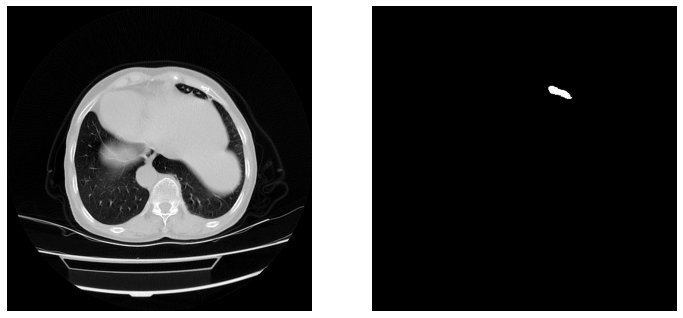

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.rot90(a[0, :,:], k=-1), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.rot90(a[1, :,:], k=-1), cmap='gray')
plt.axis('off')

plt.show()

Dataset and DataLoader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
class BasicDataset(TensorDataset):
  def __init__(self, folder, n_sample=None):
    self.folder = os.path.join(Root_Dir, folder)
      
    self.pairs_file = sorted(glob.glob(os.path.join(self.folder, '*.npy')))
    
    if not n_sample or n_sample > len(self.pairs_file):
        n_sample = len(self.pairs_file)
    
    self.n_sample = n_sample
    self.pairs_file = list([file_path for file_path in self.pairs_file])
          
  def __len__(self):
    return len(self.pairs_file)


  def __getitem__(self, i):
    file_path = self.pairs_file[i]
    idx = os.path.basename(file_path)
    data = np.load(file_path, allow_pickle=True)

    img = data[0,:,:]
    mask = data[1,:,:]

    # Add channel axis
    img = np.expand_dims(img, axis=0)
    mask = np.expand_dims(mask, axis=0)

    return {
        'image': torch.from_numpy(img).type(torch.FloatTensor),
        'mask': torch.from_numpy(mask).type(torch.FloatTensor),
        'img_id': idx
    }

In [ ]:
train_dataset = BasicDataset('/gdrive/My Drive/BMEN4460 DL in BMI Final Project/DL_data/Train/PairedData') # Change this for validation
len(train_dataset)

0

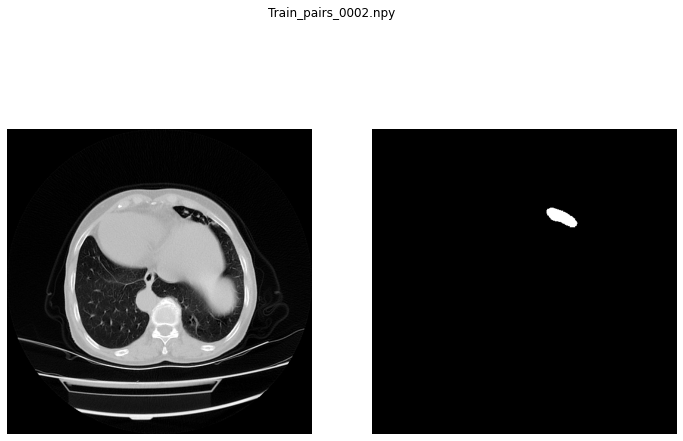

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle(data['img_id'])
plt.subplot(1,2,1)
plt.imshow(np.rot90(data['image'][0,:,:], k=-1), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.rot90(data['mask'][0,:,:], k=-1), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True) # make another loader for validation set as well

In [ ]:
EPOCHs = 50

In [ ]:
for epoch in range(EPOCHs):
  for i, data in enumerate(train_dataloader):
    images = data['image']
    masks = data['mask']

    # Train model ....

0 torch.Size([4, 1, 512, 512])
1 torch.Size([4, 1, 512, 512])
